![banner](/home/tahnik/aws-sagemaker-studio1/Training-and-Deploying-Model-with-Amazon-SageMaker-Studio1/poridhi-notebook-banner-sagemaker.gif)

# Import the SageMaker Dependencies
You need to import necessary sagemaker dependencies like session, 

which s3 bucket to be used as the storage, and,

the execution role.

In [1]:
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


#### Here, we're using the default bucket for SageMaker. You can specify your own S3 buckets for data ingestion, data processing and feature store layers ⬇️

In [21]:
print(bucket)

sagemaker-ap-southeast-1-545477210478


In [22]:
print(role)

arn:aws:iam::545477210478:role/service-role/AmazonSageMaker-ExecutionRole-20240715T135173


## You can check the specified S3 Bucket on AWS console ⬇️
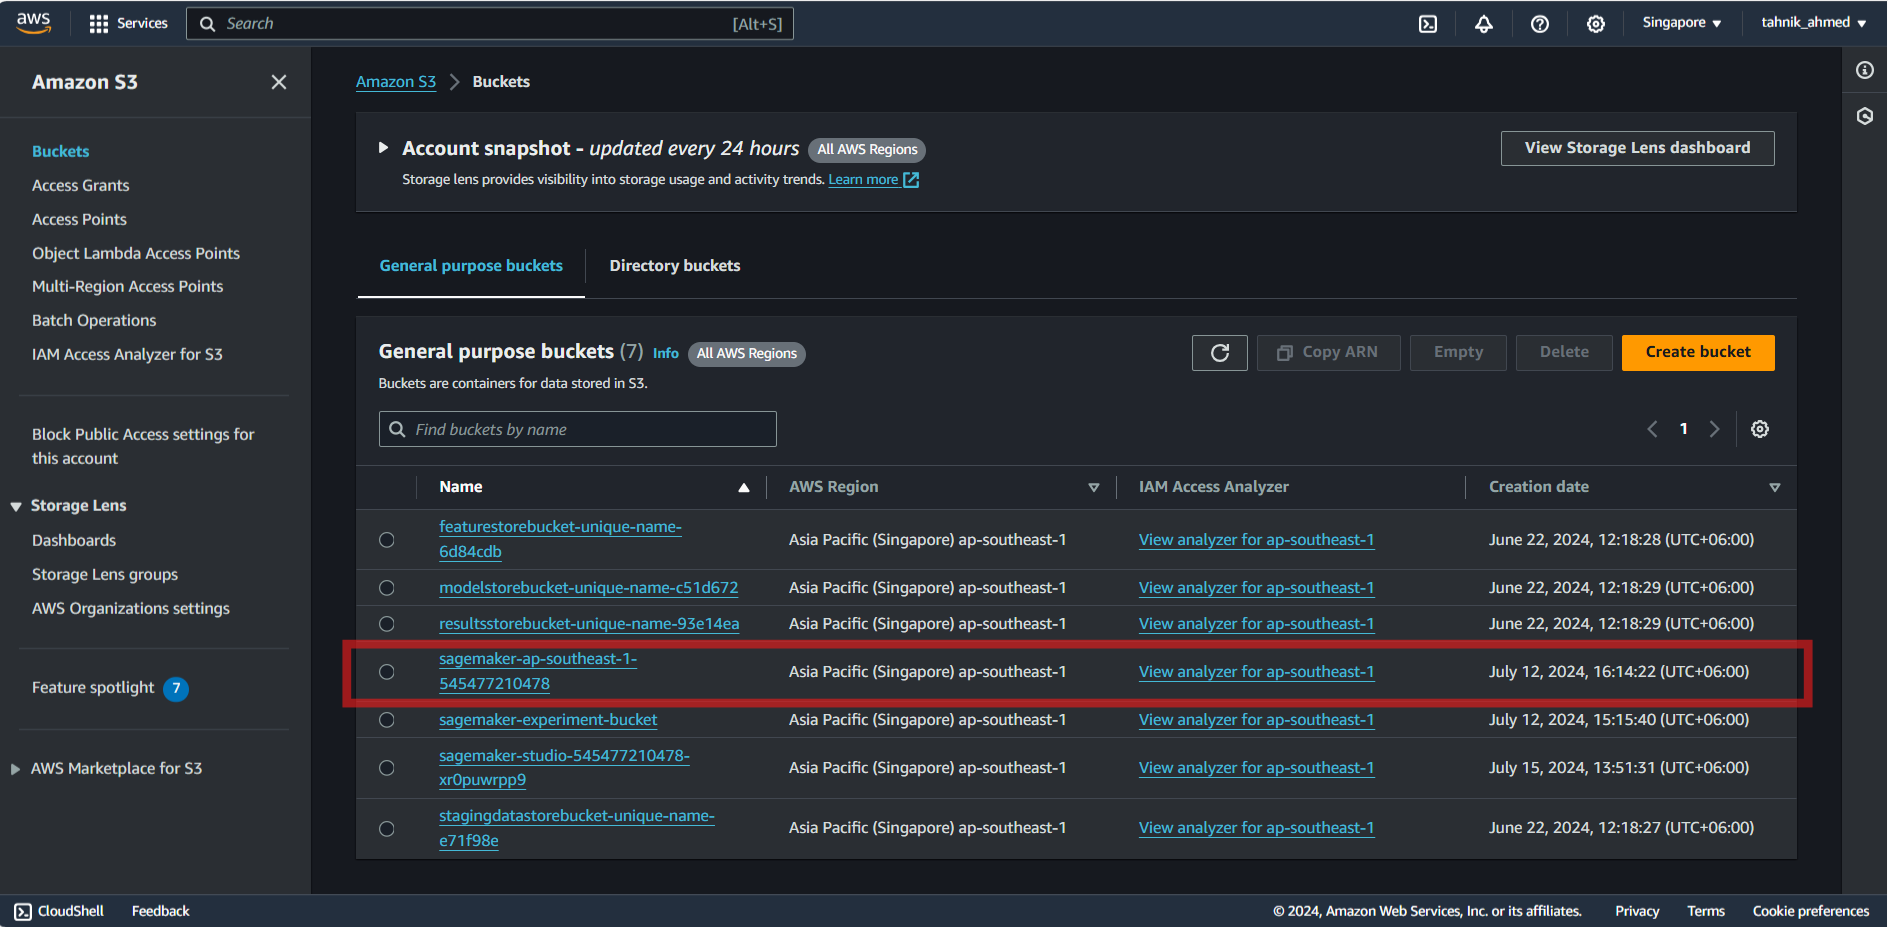

In [2]:
import pandas as pd
import numpy as np

# Download the Raw Dataset

In [4]:
!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt ./churn.txt

download: s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt to ./churn.txt


In [5]:
!head churn.txt

State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
PA,163,806,403-2562,no,yes,300,8.1622040217391,3,7.579173703343681,3.9330349941938625,4,6.508638877091394,4.065759457683862,100,5.1116239145545554,4.9281602056057885,6,5.673203040696216,3,True.
SC,15,836,158-8416,yes,no,0,10.018992664834252,4,4.226288822198435,2.3250045529370977,0,9.97259241534841,7.141039871521733,200,6.436187619334115,3.2217476231887012,6,2.559749162329034,8,False.
MO,131,777,896-6253,no,yes,300,4.708489916519045,3,4.768159882372771,4.53746627560553,3,4.566714501754875,5.363234681368032,100,5.142450865432122,7.139023052596313,2,6.254156588270942,4,False.
WY,75,878,817-5729,yes,yes,700,1.2687337723540173,3,2.567641585633793,2.528747882267883,5,2.3336236298897663,3.773585578112562,450,3.8144134221879837,2.245779327608127,6,1.0806920414898902,6,False

# Read data from CSV

In [6]:
churn_df = pd.read_csv('./churn.txt')
churn_df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,...,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,...,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,...,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,...,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,...,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.


# Dataset description

**State** – The US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ

**Account Length** – The number of days that this account has been active

**Area Code** – The three-digit area code of the customer’s phone number

**Phone** – The remaining seven-digit phone number

**Int’l Plan** – Whether the customer has an international calling plan (yes/no)

**VMail Plan** – Whether the customer has a voice mail feature (yes/no)

**VMail Message** – The average number of voice mail messages per month

**Day Mins** – The total number of calling minutes used during the day

**Day Calls** – The total number of calls placed during the day

**Day Charge** – The billed cost of daytime calls

**Eve Mins**, **Eve Calls**, **Eve Charge**– The billed cost for evening calls

**Night Mins**, **Night Calls**, **Night Charge** – The billed cost for nighttime calls

**Intl Mins**, **Intl Calls**, **Intl Charge** – The billed cost for international calls

**CustServ Calls** – The number of calls placed to customer service

**Churn?** – Whether the customer left the service (true/false)

# Data preprocessing

Remove `Phone` column

In [7]:
churn_df = churn_df.drop('Phone', axis=1)

Convert `Area Code` from `int` to string

In [8]:
churn_df['Area Code'] = churn_df['Area Code'].astype(object)

Convert result variable from `True.`/`False.` to `1`/`0`

In [9]:
churn_df['Churn?'] = np.where(churn_df['Churn?'] == 'False.', 0, 1)

Move `Churn?` column to the beginning of the table

In [10]:
churn_df = pd.concat(
    [churn_df['Churn?'], churn_df.drop(['Churn?'], axis=1)], axis=1
)

In [11]:
churn_df.head()

,Churn?,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,1,PA,163,806,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3
1,0,SC,15,836,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8
2,0,MO,131,777,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4
3,0,WY,75,878,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6
4,1,WY,146,878,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6


Use one hot encoding for non-numeric fields.

In [12]:
churn_df = pd.get_dummies(churn_df)

In [13]:
churn_df.head()

,Churn?,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,...,Area Code_858,Area Code_866,Area Code_868,Area Code_876,Area Code_877,Area Code_878,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,1,163,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,...,False,False,False,False,False,False,True,False,False,True
1,0,15,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,...,False,False,False,False,False,False,False,True,True,False
2,0,131,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,...,False,False,False,False,False,False,True,False,False,True
3,0,75,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,...,False,False,False,False,False,True,False,True,False,True
4,1,146,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,...,False,False,False,False,False,True,False,True,True,False


# Data splitting

### Randomly shuffle the dataset

In [14]:
churn_df_shuffled = churn_df.sample(frac=1, random_state=42)

### Split datset into train/validation/test datasets

In [15]:
churn_df_len = len(churn_df_shuffled)
churn_df_train, churn_df_validate, churn_df_test = np.split(
    churn_df_shuffled, 
    [
        int(0.6 * churn_df_len),
        int(0.8 * churn_df_len)
    ]
)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Write datsets as CSV files. 

We want to write a file without row names (`index=False`) and without a CSV header (`header=False`)

In [16]:
churn_df_train.to_csv('churn_train.csv', header=False, index=False)
churn_df_validate.to_csv('churn_validate.csv', header=False, index=False)

### Copy result files to S3

In [17]:
!aws s3 cp churn_train.csv s3://{bucket}/churn_train.csv
!aws s3 cp churn_validate.csv s3://{bucket}/churn_validate.csv

upload: ./churn_train.csv to s3://sagemaker-ap-southeast-1-545477210478/churn_train.csv
upload: ./churn_validate.csv to s3://sagemaker-ap-southeast-1-545477210478/churn_validate.csv


## You can check the newly stored train and validation files on the specified S3 Bucket ⬇️
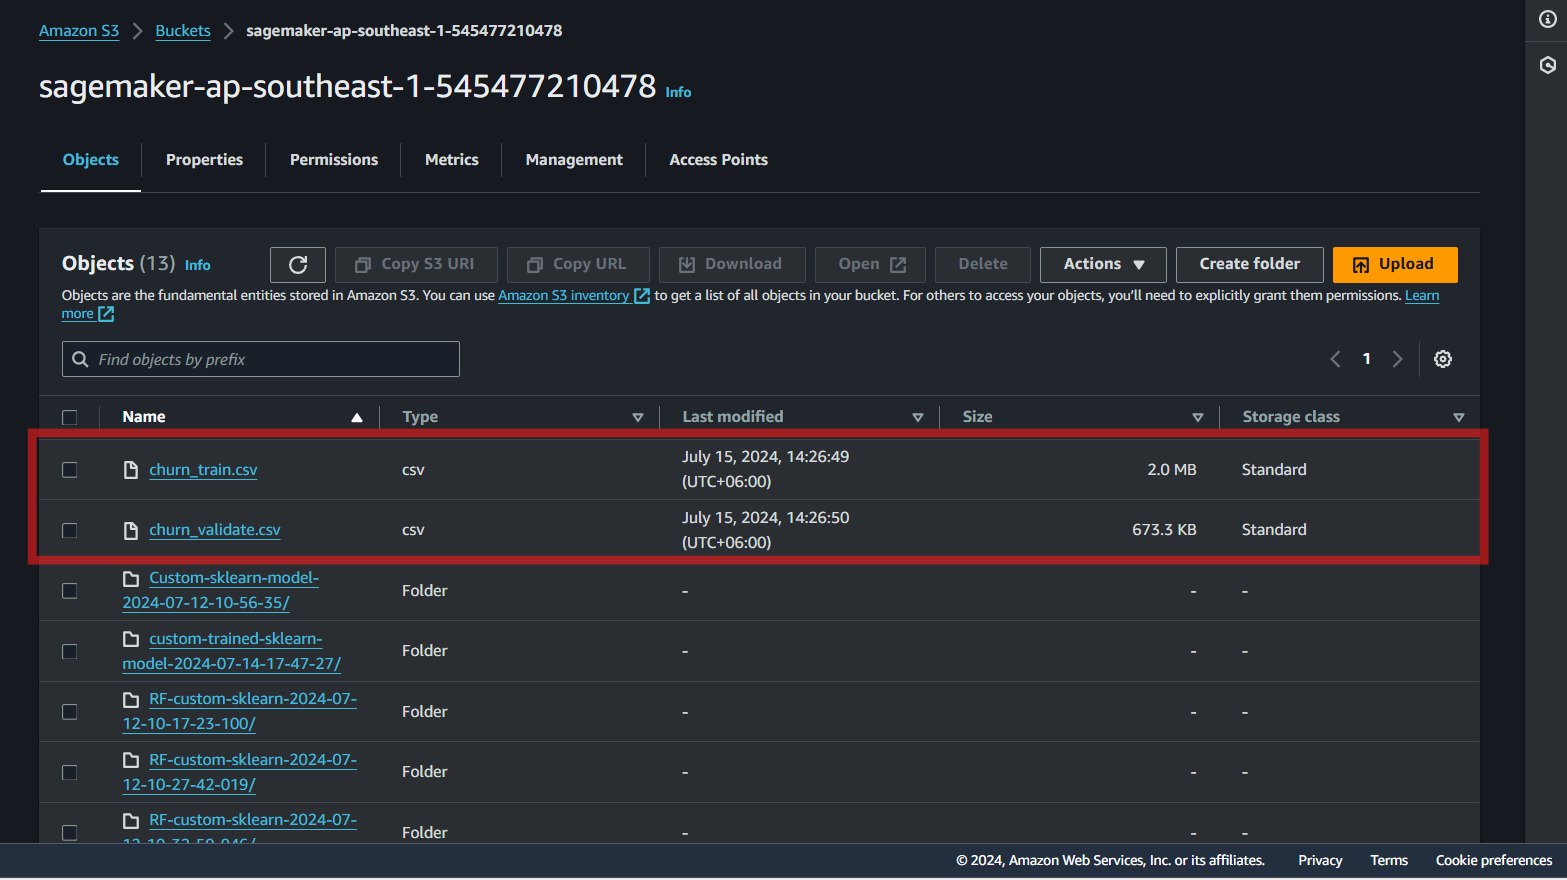

# Create inputs for the estimator

In [18]:
from sagemaker.inputs import TrainingInput

s3_input_train = TrainingInput(
    s3_data=f's3://{bucket}/churn_train.csv', content_type='csv'
)
s3_input_validate = TrainingInput(
    s3_data=f's3://{bucket}/churn_validate.csv', content_type='csv'
)

# Load a container XGBoost algorithm
SageMaker provides three ways to train machine learning models,

1. Using Built-in Algorithms
2. Using Custom Scripting
3. Using Custom Container Images

In [19]:
xgb_image = sagemaker.image_uris.retrieve('xgboost', session.boto_region_name, '1.5-1')

# Start Training the Model with the container XGBoost Algorithm

**Initialize Estimator:** An XGBoost estimator is created with specific configurations like the machine type (ml.m5.large), the location for saving output (s3://{bucket}/output), and the AWS role for permissions.

**Set Hyperparameters:** The model is configured for binary classification (binary:logistic) with a maximum tree depth of 5 and 100 training rounds.

**Train Model:** The model training is initiated using training and validation datasets stored in S3.

In [20]:
xgb = sagemaker.estimator.Estimator(
    xgb_image,
    role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/output',
    sagemaker_session=session,
)
xgb.set_hyperparameters(
    max_depth=5,
    objective='binary:logistic',
    num_round=100,
)

xgb.fit(
    {
        'train': s3_input_train,
        'validation': s3_input_validate
    }
)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-07-15-08-31-12-935


2024-07-15 08:31:13 Starting - Starting the training job...
2024-07-15 08:31:29 Starting - Preparing the instances for training...
2024-07-15 08:31:53 Downloading - Downloading input data...
2024-07-15 08:32:33 Downloading - Downloading the training image......
2024-07-15 08:33:44 Training - Training image download completed. Training in progress.
2024-07-15 08:33:44 Uploading - Uploading generated training model./miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-07-15 08:33:38.536 ip-10-0-116-21.ap-southeast-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-07-15 08:33:38.558 ip-10-0-116-21.ap-southeast-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-07-15:08:33:38:INFO] Imported framework sagemaker_xg

# Check the Model Artifacts in the specified model output path on the S3 bucket
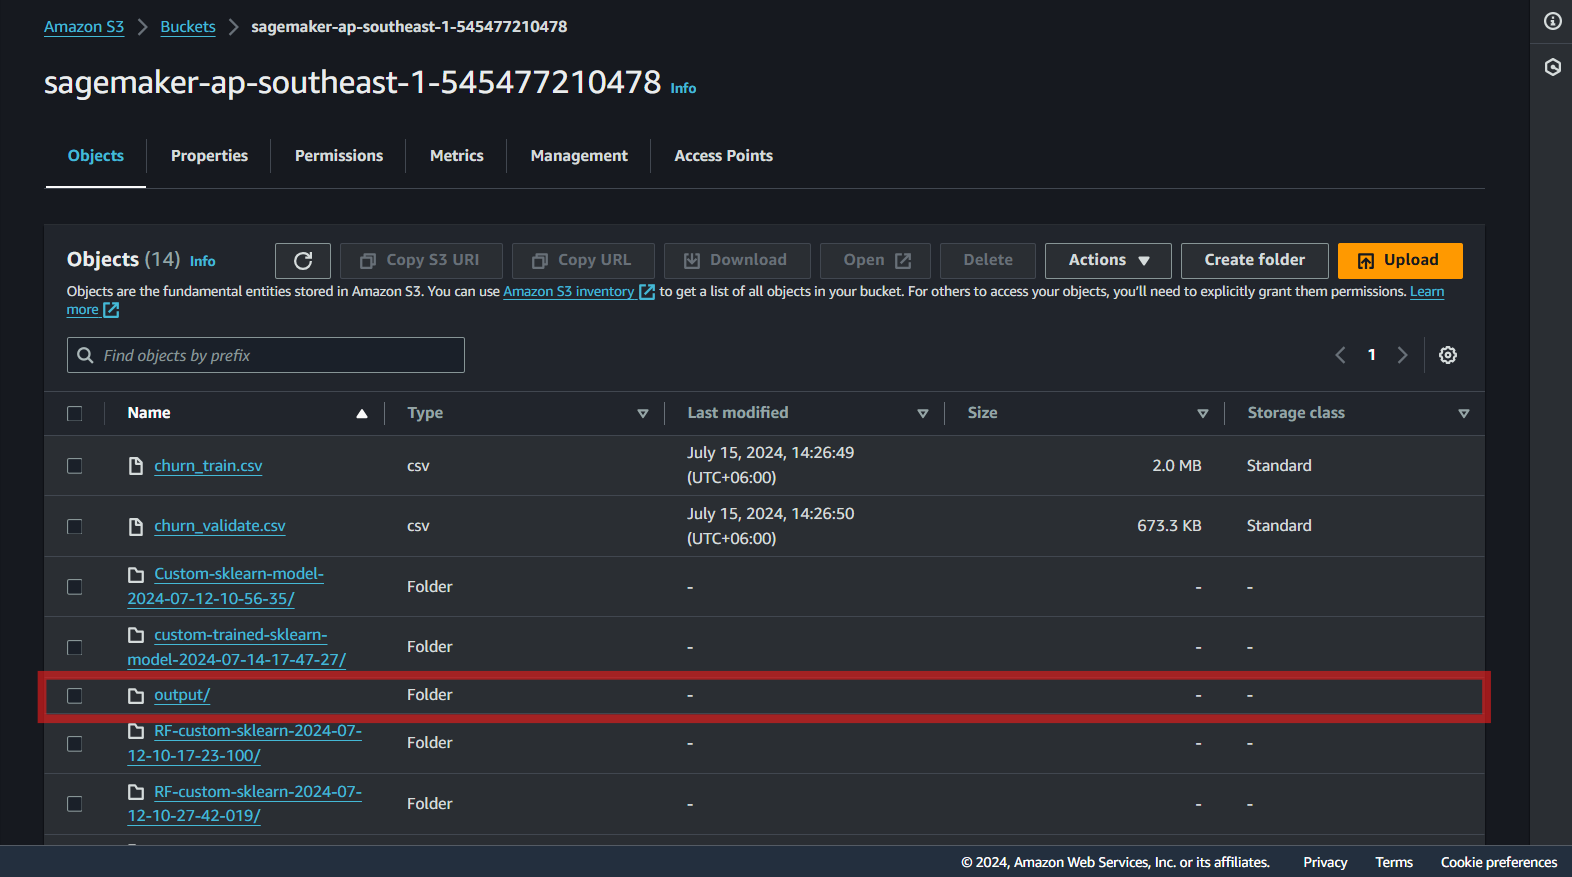

#### You can find the trained model in the following directory of that folder ⬇️
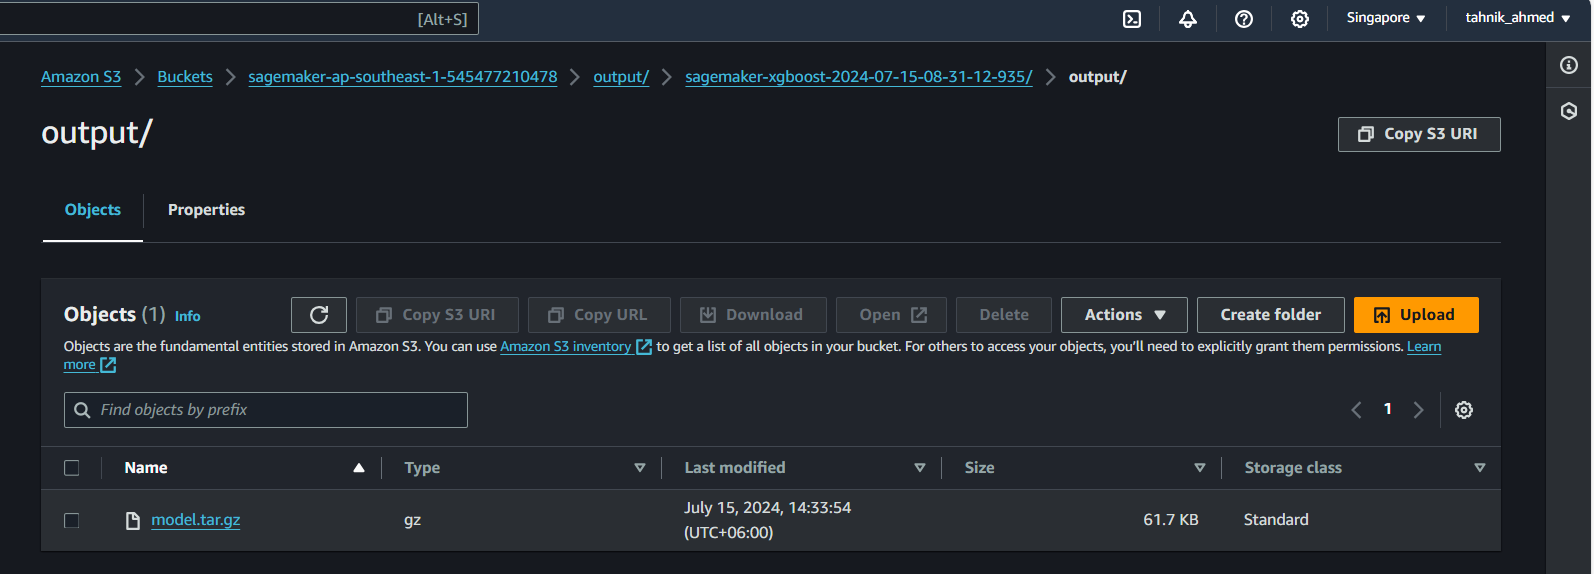

#### Follow the next notebook to deploy this newly trained model ⏬